In this notebook I am going to share with you some models I developed for predicting the finishing times of runners competing in the 2017 Berlin Marathon.

I already scraped the data from the official Berlin Marathon website and did some preprocessing to create the CSV file: 'Berlin_Marathon_2017_Results_Clean.txt' It contains a row for each of the over 39,000 finishers with their age, gender, country, starting time and finishing time (net: when they cross the starting line to when they cross the finishing line). In marathons of this size, some of the runners don't even cross the start line until almost an hour after the gun goes off!

Let's start by loading the libraries we'll be using: the machine learnning models come from scikit-learn, I use pandas and numpy dataframes and series to store my data, and the visualizations come from matplotlib and seaborn.

In [14]:
import pandas as pd
import numpy as np

import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import StandardScaler

from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV

from sklearn.dummy import DummyRegressor
from sklearn.tree import DecisionTreeRegressor, export_graphviz
from sklearn.linear_model import LinearRegression, Ridge
from sklearn.ensemble import RandomForestRegressor

from sklearn.metrics import mean_squared_error, mean_absolute_error

import warnings

In [25]:
#Ignore depracation warnings for this notebook
warnings.filterwarnings('ignore')

The csv file contains the following features: age, gender, country, start time (in terms of minutes after the starting gun that the runner crosses the starting line), and finishing time (in minutes).

In [16]:
#Load the CSV file - it's already been scraped and preprocessed
Results = pd.DataFrame
Results = pd.read_table('Berlin_Marathon_2017_Results_Clean.txt', delimiter=',')

Results = Results.astype({"Age": int, 'Time': float, 'Start Time': float})

I start with some exploratory data analysis to get a feel for the data and see if there are any quirks to watch out for.

Graphing the runners by gender, you can see that there are a lot more male runners than female runners.

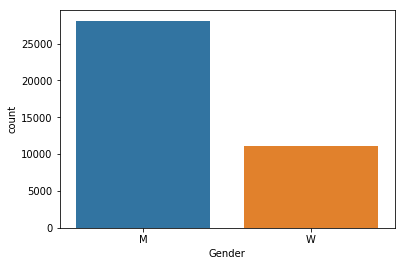

In [17]:
sns.countplot(x='Gender', data=Results)

Next, I group the runners by country to see how many countries are represented and which have the most runners. Germany has the highest number of runners by far, with more than 6 times as many as the next highest country: Great Britain. This makes sense since the race takes place in Germany and Germany is the most populated country in Europe. On the other end of the spectrum, there are 24 countries that only have one representative.

In total, there are 135 countries represented.

In [18]:
Results_by_Country = Results.groupby('Country', as_index=False).count()[['Country', 'Time']]
Results_by_Country = Results_by_Country.sort_values(by = ['Time'], ascending = False)
print(Results_by_Country.head())
print('There are ' + str(len(Results_by_Country)) + ' countries represented')

Countries_with_one_Runner = Results_by_Country[Results_by_Country['Time'] == 1]
print(Countries_with_one_Runner)
print('There are ' + str(len(Countries_with_one_Runner)) + ' countries with only one runner competing')


    Country   Time
46      GER  15880
45      GBR   2505
130     USA   2026
31      DEN   1712
43      FRA   1466
There are 135 countries represented
    Country  Time
127     UGA     1
121     TOG     1
10      BAR     1
22      CMR     1
23      COD     1
27      CUB     1
123     TRI     1
133     ZAM     1
28      CUW     1
41      FIJ     1
32      DMA     1
119     TAN     1
89      MYA     1
44      FRO     1
50      GUI     1
51      GUY     1
73      LAO     1
107     SEN     1
76      LIE     1
83      MDV     1
87      MLT     1
103     QAT     1
88      MTN     1
0       AFG     1
There are 24 countries with only one runner competing


An interesting pattern arises when looking at a historgram of the start times. It looks like the runners take off in 3 separate blocks, with a gap of over 10 minutes between each block. 

To deal with the large number of runners and prevent congestion at the start, and throughout the race, it is typical for the runners to be divided into groups based on their projected finishing times, with the faster runners starting at the front. However, the number of groups, the length of time between the groups, and the amount of people that can cross the starting line at the same time, varies based on the marathon. And even from year to year at the same marrathon. That means this feature must be carefully looked at when applying models between different marathons or years.

Even within the same year, it could cause issues, especially for linear models. It is unlikely to affect decision trees (and therefore random forests).

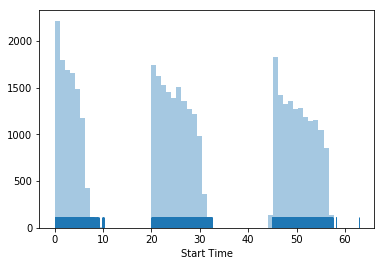

In [19]:
sns.distplot(Results['Start Time'], bins = 60, kde=False, rug=True)

Since I'd like to use some linear models, and also build a model that can scale to other years and other marathons, I decideded to delete the gaps between the blocks. To do this, I decided to "stop" the start watch when less than 2 runners per second cross the starting line (measured by the minute, so when less than 120 runners cross the starting line in a minute). I chose this method because it can be decided before the race, and therefore could be used at the beginning of another race if I wanted to predict the results in real time.

In [20]:
Results['Start Minute'] = np.floor(Results['Start Time'])
Results_by_Start_Minute = Results.groupby('Start Minute', as_index=False).count()[['Start Minute', 'Time']]
print(Results_by_Start_Minute)

    Start Minute  Time
0            0.0  2116
1            1.0  1724
2            2.0  1622
3            3.0  1578
4            4.0  1474
5            5.0  1249
6            6.0   669
7            7.0    65
8            8.0    23
9            9.0     4
10          10.0     3
11          20.0  1764
12          21.0  1549
13          22.0  1453
14          23.0  1437
15          24.0  1296
16          25.0  1436
17          26.0  1294
18          27.0  1247
19          28.0  1178
20          29.0  1038
21          30.0   659
22          31.0    97
23          32.0    20
24          45.0  1745
25          46.0  1389
26          47.0  1271
27          48.0  1317
28          49.0  1219
29          50.0  1244
30          51.0  1168
31          52.0  1082
32          53.0  1079
33          54.0  1074
34          55.0   933
35          56.0   606
36          57.0    25
37          58.0     3
38          62.0     1


That means everyone who started in the second block (20:00 to 45:00 after the gun) will have 13 minutes subtracted from their start time (20 - 7). And everyone who started in the third block (> 45:00), will have 27 minutes subtracted from their start time ((20 - 7) + (45 - 31)). 

Looking at the histogram of adjusted start times, there are now no big gaps between the starting groups.

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 39151 entries, 0 to 39150
Data columns (total 5 columns):
Country                39151 non-null object
Gender                 39151 non-null object
Age                    39151 non-null int32
Time                   39151 non-null float64
Adjusted Start Time    39151 non-null float64
dtypes: float64(2), int32(1), object(2)
memory usage: 1.3+ MB
None


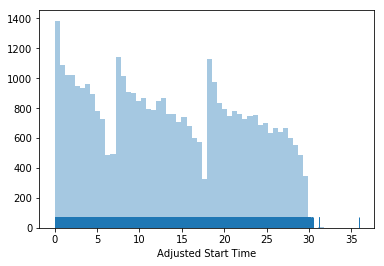

In [21]:
def adj_start(x):
    if x < 20:
        return x
    elif x < 45:
        return x - 13
    else:
        return x - 27
Results['Adjusted Start Time'] = Results['Start Time'].map(lambda x: adj_start(x))
sns.distplot(Results['Adjusted Start Time'], bins = 60, kde=False, rug=True)

Results = Results.drop('Start Time', axis = 1)
Results = Results.drop('Start Minute', axis = 1)
print(Results.info())

To make the features work with a variety of regressors, I have to one hot encode the categorical data, as well as scale the numerical data.

In [22]:
le_gender = LabelEncoder()
Results['Gender'] = le_gender.fit_transform(Results['Gender'])

ohe_country = OneHotEncoder(categories='auto')
X = ohe_country.fit_transform(Results.Country.values.reshape(-1,1)).toarray()
CountryOneHot = pd.DataFrame(X, columns = ["Country_"+str(int(i)) for i in range(X.shape[1])])
Results = pd.concat([Results, CountryOneHot], axis=1)
Results = Results.drop('Country', axis=1)

Now I divide the data into a train set and test set, and then separate the features from the target, which is the net finishing time.

In [23]:
train_set, test_set = train_test_split(Results, test_size=.2, random_state=40)

y_train, y_test = train_set['Time'], test_set['Time']
X_train, X_test = train_set.drop('Time', axis=1), test_set.drop('Time', axis=1)

I also have to scale the data for it to work better with certain models, like Ridge Regressions.

In [26]:
standardScalerX = StandardScaler()
standardScalerX.fit(X_train)
X_train = standardScalerX.transform(X_train)
X_test = standardScalerX.transform(X_test)

I first run a dummy regressor that predicts the same time for each runner: the mean finishing time of the train data. It gives a mean absolute error of 36.6 minutes on the test data.

In [27]:
dummy = DummyRegressor()
dummy.fit(X_train, y_train)
y_test_dummy_pred = dummy.predict(X_test)
mean_squared_error_dummy_predict = mean_squared_error(y_test, y_test_dummy_pred)
mean_abs_error_dummy_predict = mean_absolute_error(y_test, y_test_dummy_pred)
print('mean squared error error = ' + str(mean_squared_error_dummy_predict))
print('mean absolute error = ' + str(mean_abs_error_dummy_predict))

mean squared error error = 2115.2026126590017
mean absolute error = 36.574535934972396


My first model will be a Ridge Regression. To find the best hyperparameters to use, I will first use grid search with a wide range of possible values for alpha, measuring its accuracy with 5-fold cross-validation. 

In [28]:
ridge = Ridge()
ridge_parameters = {'alpha': ['.01', '.1', '1', '10', '100', '200', '1000']}
clf = GridSearchCV(ridge, ridge_parameters, cv=5)
clf.fit(X_train, y_train)
print(clf.best_params_)

{'alpha': '100'}


The first run shows that the best results come with alpha = 100, but I will do another run to see if any other values between 10 and 200 work better.

In [29]:
ridge = Ridge()
ridge_parameters = {'alpha': ['10', '30', '50', '70', '90', '110', '130', '150', '170', '190']}
clf = GridSearchCV(ridge, ridge_parameters, cv=5)
clf.fit(X_train, y_train)
print(clf.best_params_)

{'alpha': '150'}


I will now set alpha equal to 150 and put that into a Ridge Regression, which I then run on the test data. I get get a mean absolute error of 23.1 minutes, a decrease of about 46 percent compared to the dummy regressor.

In [35]:
reg = Ridge(alpha=150)
reg.fit(X_train, y_train)
y_test_ridge_pred = reg.predict(X_test)
mean_squared_error_ridge_predict = mean_squared_error(y_test, y_test_ridge_pred)
mean_abs_error_ridge_predict = mean_absolute_error(y_test, y_test_ridge_pred)
print('mean squared error error = ' + str(mean_squared_error_ridge_predict))
print('mean absolute error = ' + str(mean_abs_error_ridge_predict))

mean squared error error = 959.002460282394
mean absolute error = 23.117512097684997


As a second model, I would like to try a random forest regression. Once again, I use grid search with 5-fold cross-validation to see what values for the hyperparameters n_estimators and max_depth work best.

In [33]:
forest_cv = RandomForestRegressor(random_state = 40)
forest_parameters = {'n_estimators': [5, 20, 50, 80], 'max_depth': [5, 10, 20]}
clf_forest = GridSearchCV(forest_cv, forest_parameters, cv=5)
clf_forest.fit(X_train, y_train)
print(clf_forest.best_params_)

{'max_depth': 10, 'n_estimators': 80}


Setting the hyperparameter n_estimator to 80 and max_depth to 10 gives a mean absolute error of 22.5 on the test set, a decrease of 2.5 percent from the mean absolute error of the Ridge Regression.

In [36]:
forest = RandomForestRegressor(n_estimators = 80, max_depth = 10)
forest.fit(X_train, y_train)
y_test_forest_pred = forest.predict(X_test)
mean_squared_error_forest_predict = mean_squared_error(y_test, y_test_forest_pred)
mean_abs_error_forest_predict = mean_absolute_error(y_test, y_test_forest_pred)
print('mean squared error error = ' + str(mean_squared_error_forest_predict))
print('mean absolute error = ' + str(mean_abs_error_forest_predict))

mean squared error error = 930.7823960170693
mean absolute error = 22.55349775850011


In total, we looked at three prediction models: a dummy regression, ridge regression, and random forest regression. As can be expected, the dummy regressor performed the worst. The ridge and random forest worked almost 50 percent better, with the random forest regression working the best.

The next step is to take these models and expand them to other years of the Berlin Marathon, and then to other marathons.

There are a few things I will keep in mind when adding other years of the Berlin Marathon:
- The course of the Berlin marathon stays mostly the same, and the organizers will always try to make it as fast as possible for world record attemps: this is not anything that needs to be adjusted for
- Demographics of the runners may change, but including features like country, age, and gender will control for some of that.
- Not controlled for is the increase in the number of casual runners attempting marathons. I am not sure if there is an easy way to find out this information.
- Every year there is more and more knowledge being gained about how to effectively train for a marathon, which will lead to faster times. Looking at overall trends over the years could bring insight into this area.
- The organizers might decide to change the starting blocks and / or gap between starting groups. This could lead to adjusting the starting time feature in some way that makes it consistent across years.

And some things I will keep in mind when adding other marathons:
- Different cities have different courses and different weather: this can lead to huge differences in average times. Even if I don't have the complete data on the historical results of a given marathon, I might be able to find average times of finishers or winning times, which could then be used to adjust the predicted times upwards or downwards by certain factors.
- The organizers will have different ways of dividing the runners into starting groups and different rates of runners crossing the starting line. I might have to adjust the model from a time based model to a percentile based model showing where someone starts the race in relation to the other participants.
- There are different participant demographics in different countries - some will automatically be controlled for, like country, age, and gender. Others won't be, like the number of casual runners participating versus more serious runners. 

If you are interested in tackling any of these problems with me, feel free to send me a message and perhaps we could find a way to work together.